<a href="https://colab.research.google.com/github/ZulfiiaDitto/BalancingStrategiesForImageDataset/blob/main/Numba_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to practice Numba python compailer. The documentation for it located in this url: https://numba.readthedocs.io/en/stable/user/5minguide.html



In [ ]:
# inatalling the numba ( you can also use !conda install numba -> if you in conda enviroment)
!pip install numba

In [24]:
from numba import jit, guvectorize, int64, int32, njit, vectorize
import numpy as np
import timeit
import matplotlib.pyplot as plt

In [3]:
a = np.arange(5)

## njit/jit compiler


In [4]:
# in order to compare the speed of the functions. First lets create simple function in python as a baseline
def mult_add_py(x, y):
    return 2*x + y

# and see how long it will take to run it
timeit.timeit(lambda: mult_add_py(a, 2), number=1000000)

7.667985682999998

In [5]:
# now let's use numba
@njit()
def mult_add(x, y):
    return 2*x + y
timeit.timeit(lambda: mult_add(a, 2), number=1000000)


7.0334687500000115

In [6]:
# we provide only the type for the input function -> and as a result Numba infer for us the output result
@njit([(int64, int64)])
def mult_add_eagar(x, y):
    return 2*x + y

mult_add_eagar(x=2.0, y=6.7)

10

In [7]:
# we put the output and input signatures for the function -> as a resut it is infer for us the result -> instead of float we are getting int
 # (per documentation the higher-order bits get discarded)
@njit([int64(int64, int64)])
def mult_add_eagar_3(x, y):
    return 2*x + y

mult_add_eagar_3(x=2.0, y=6.7)

10

In [8]:
# putting the wrong type into function -> getting error
mult_add_eagar_3(x=[2], y=6)

TypeError: No matching definition for argument type(s) reflected list(int64)<iv=None>, int64

In [9]:
time_lst = []
val = 100
# keep in mind that timeit.timeit is giving you an average time
for n in range(val):
    time = timeit.timeit(lambda: mult_add(a, 2), number = 1000)
    #print(n, time)
    time_lst.append(time)



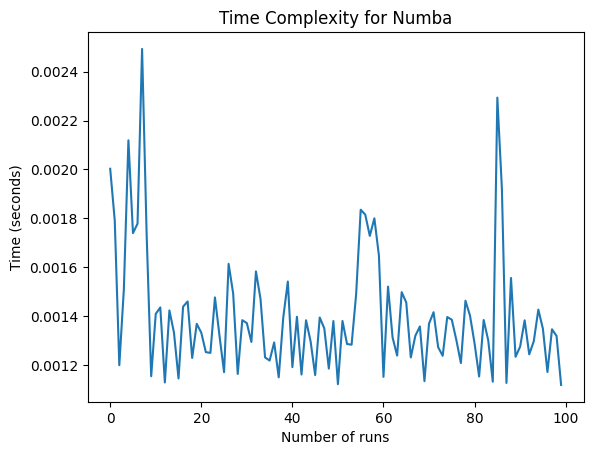

In [11]:
# Plot the results
plt.plot(range(val), time_lst)
plt.xlabel('Number of runs')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity for Numba')
plt.show()

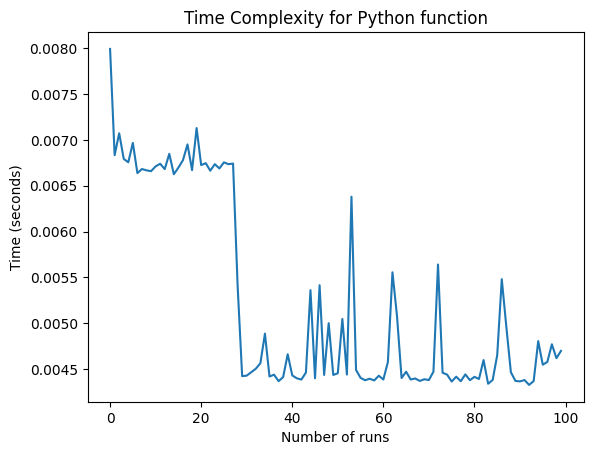

In [13]:
time_lst_py = []
val_py = 100
# keep in mind that timeit.timeit is giving you an average time
for n in range(val_py):
    time = timeit.timeit(lambda: mult_add_py(a, 2), number = 1000)
    #print(n, time)
    time_lst_py.append(time)

# Plot the results
plt.plot(range(val_py), time_lst_py)
plt.xlabel('Number of runs')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity for Python function')
plt.show()

In [14]:
# lets use the parallel parameter for the njit compiler to speed up even more
@njit(parallel = True)
def mult_add_parallel(x, y):
    return 2*x + y

# this is time with parallel processing, and WOW! it is much slower! why?
# because my task is too small, so setting up all the parallel threads and managing them is adding a lot of overhead
# and those processes are negating the speed up of Numba

timeit.timeit(lambda: mult_add_parallel(a, 2), number=1000000)

12.889535844000022

#vectorize and guvectorize decorators


In [52]:
# more examples
# adding and multipling vectors
@vectorize
def add_vectors(array1,array2):
    return 2*array1+2*array2


In [57]:
# it is drastically faster when you use it on top of numpy calculation
add_numba = timeit.timeit(lambda: add_vectors(np.array([1.,2,3]),np.array([2.,3,4])), number = 100000)
add_numba

0.35919292300013694

In [58]:
add_numpy = timeit.timeit(lambda: np.add(2*np.array([1.,2,3]),2*np.array([2.,3,4])), number = 100000)
add_numpy

0.6854783099997803

In [59]:
# almost two times faster than numpy functions
add_numba/add_numpy

0.5240033386326287

In [75]:
# another exmaple
# adding scalar to vector
@guvectorize([(int64[:], int64, int64[:])], '(n),()->(n)')
def g_vec(x, y, res):
    for i in range(x.shape[0]):
        res[i] = x[i] + y

In [68]:
timeit.timeit(lambda: g_vec(a, 2), number=1000000)

2.709993280999697

In [70]:
timeit.timeit(lambda: np.array(a) + 2, number=1000000)

1.8523845559998335

In [90]:
# the dot product example

@guvectorize([(int64[:], int64[:], int64[:])], '(n),(n)->(n)')
def dot_product(array1, array2, res):
    for i in range(array1.shape[0]):
        res[i] = array1[i] * array2[i]


In [100]:
timeit.timeit(lambda: dot_product(np.array([2,3,4]), np.array([2,3,4])), number=1000000)

2.8851915140003257

In [101]:
timeit.timeit(lambda: np.dot(np.array([2,3,4]), np.array([2,3,4])), number=1000000)

4.218354667999847

# Pandas and Numba

In [104]:
import pandas as pd

## custom function with Numba

In [106]:
# lest create a fake df of prescriptions. the first column is the number of tabs/caps per day,
# and the tabs number is the total number of tabs that are dispensed.
# let's try to find the day supply by 'number of tabs dispensed'/'tabs per day'

df = pd.DataFrame({'tabs per day': [2, 3, 1, 3, 2, 1], 'number of tabs dispensed': [30, 60, 90, 90, 30, 60]})
df

,tabs per day,number of tabs dispensed
0,2,30
1,3,60
2,1,90
3,3,90
4,2,30
5,1,60


In [107]:
# the day supply calcualtion
@jit
def day_supply_calc(dispensed_amount, number_tab):
    return dispensed_amount/number_tab

In [113]:
# take the funtion above and integrate it into the pandas dataframe
@jit
def integrate_day_suply(col_dispense_amount, col_number_tab):
    n = len(col_dispense_amount)
    result = np.zeros(n)
    for i in range(n):
        result[i] = day_supply_calc(col_dispense_amount[i], col_number_tab[i])
    return result

In [114]:
# now lets create the python function which we will apply to df
def compute_day_supply(df):
    result = integrate_day_suply(
        df["number of tabs dispensed"].to_numpy(), df["tabs per day"].to_numpy())
    return pd.Series(result, index=df.index, name="day supply")

In [111]:
# Standard implementation
%timeit df["result"] = df['number of tabs dispensed']/ df['tabs per day']

251 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [115]:
# Custom function with numba
%timeit df["result_numba"] = compute_day_supply(df)

181 µs ± 83.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba engine

In [136]:
def compute_mean(a):
    return sum(a)/len(a)

In [126]:
df

,tabs per day,number of tabs dispensed,result,result_numba
0,2,30,15.0,15.0
1,3,60,20.0,20.0
2,1,90,90.0,90.0
3,3,90,30.0,30.0
4,2,30,15.0,15.0
5,1,60,60.0,60.0


In [139]:
#numba engine
%time df['result_mean_numba_engine'] = df[['number of tabs dispensed']].apply(compute_mean,axis=1, engine='numba', raw =True)

CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 2.84 ms


In [140]:
# standard implementation with apply
%time df['result_mean'] = df[['number of tabs dispensed']].apply(compute_mean,axis=1)

CPU times: user 3.74 ms, sys: 868 µs, total: 4.61 ms
Wall time: 5.52 ms


In [141]:
# standard implementation with mean function
%time df['result_mean_numba_engine'] = df[['number of tabs dispensed']].mean()

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.7 ms
